In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv 
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from data_repository import DataRepository

In [2]:
data_repo = DataRepository("../.env")
#Clean data FFT
train_ampls, y_train, validation_ampls, y_validation, _, _ = data_repo.load_fft_data(clean_data=True)
_, _, _, _, test_ampls, y_test = data_repo.load_fft_data(clean_data=False)

In [3]:
#Clean data current
X_train_current, _, X_val_current, _, _, _ = data_repo.load_current_data(clean_data=True)
_, _, _, _, X_test_current, _ = data_repo.load_current_data(clean_data=False)

In [4]:
print(f"Train dataset: X: {train_ampls.shape}, {X_train_current.shape}, y: {y_train.shape}")
print(f"Validation dataset: X: {validation_ampls.shape}, {X_val_current.shape}, y: {y_validation.shape}")
print(f"Test dataset: X: {test_ampls.shape}, {X_test_current.shape}, y: {y_test.shape}")

Train dataset: X: (8290, 4501), (8290, 9000), y: (8290,)
Validation dataset: X: (1778, 4501), (1778, 9000), y: (1778,)
Test dataset: X: (1800, 4501), (1800, 9000), y: (1800,)


__Label encoder__

In [5]:
# Chuyển đổi danh sách labels thành mã số
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)
y_test = label_encoder.transform(y_test)

In [6]:
print(list(label_encoder.classes_))
print(label_encoder.transform(list(label_encoder.classes_)))

['error', 'normal', 'overcurrent', 'overheating', 'zero']
[0 1 2 3 4]


# Feature selection

In [7]:
def find_top_k_indices(amplitudes, k):
    # Get the indices of the top 50 elements
    top_k_indices = np.argsort(amplitudes)[-k:][::-1]
    highest_ampls = amplitudes[top_k_indices]
    return highest_ampls

def get_x_by_top_ampls(k, ampls):
    X = []
    for ampl in ampls:
        X.append(find_top_k_indices(amplitudes=ampl, k=k))
    return np.array(X)

In [8]:
X_train_1 = get_x_by_top_ampls(k=1, ampls=train_ampls)
X_train_601 = get_x_by_top_ampls(k=601, ampls=train_ampls)

X_validation_1 = get_x_by_top_ampls(k=1, ampls=validation_ampls)
X_validation_601 = get_x_by_top_ampls(k=601, ampls=validation_ampls) 

X_test_1 = get_x_by_top_ampls(k=1, ampls=test_ampls)
X_test_601 = get_x_by_top_ampls(k=601, ampls=test_ampls)

In [9]:
X_all_601 = np.concatenate([X_train_601, X_validation_601])
X_all_1 = np.concatenate([X_train_1, X_validation_1])
y_all = np.concatenate([y_train, y_validation])

In [10]:
print(X_train_1.shape, X_validation_1.shape, X_train_601.shape, X_validation_601.shape, X_all_601.shape, X_all_1.shape, y_all.shape)

(8290, 1) (1778, 1) (8290, 601) (1778, 601) (10068, 601) (10068, 1) (10068,)


In [11]:
def evaluate_and_print_results(model, X_test, y_test, label_encoder: LabelEncoder):
    # Dự đoán nhãn cho tập test
    y_test_pred = model.predict(X_test)

    # Tính toán độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)
    
    #conf_matrix to return
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Tính toán F1-Score
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    #Precision and recall
    precision = precision_score(y_test, y_test_pred, average='weighted')  
    recall = recall_score(y_test, y_test_pred, average='weighted')
    #AUC
    
    # Dự đoán scores để tính AUC
    y_test_scores = model.predict_proba(X_test)
    
    # Tính AUC cho từng lớp và tính trung bình (macro-average) AUC
    n_classes = len(np.unique(y_test))  # Assuming labels start from 0
    auc_values = []
    for i in range(n_classes):
        # Create binary labels for each class
        y_test_class = np.where(y_test == i, 1, 0)
        auc = roc_auc_score(y_test_class, y_test_scores[:, i])
        auc_values.append(auc)
    # Tính trung bình AUC (macro-average)
    macro_avg_auc = np.mean(auc_values) if len(auc_values) > 0 else 0  # Avoid division by zero if auc_values is empty
    
    #Revert transform
    y_test = label_encoder.inverse_transform(y_test)
    y_test_pred = label_encoder.inverse_transform(y_test_pred)
    
    # Print results
    print(classification_report(y_test, y_test_pred))
    print()
    print("Custom reports")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score (Micro): {f1_micro}")
    print(f"F1-Score (Macro): {f1_macro}")
    print(f"F1-Score (Weighted): {f1_weighted}")
    print(f"Macro-average AUC (SVM): {macro_avg_auc}")
    
    return conf_matrix

def conf_matrix_plot(conf_matrix, model_name):
    # Define the class labels
    class_labels = ['error', 'normal', 'overcurrent', 'overheating', 'zero']

    # Create a mappable object for the confusion matrix.
    mappable = plt.imshow(conf_matrix, cmap='Blues')

    # Plot the colorbar.
    plt.colorbar(mappable)

    # Add labels to the plot using the class labels.
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)

    # Add text to the confusion matrix.
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center')

    # Set plot title and labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'{model_name} confusion matrix')

    plt.show()

# Model training

## SVM

In [12]:
from sklearn.svm import SVC
# default
svm_current = SVC(kernel='rbf', random_state=42, probability=True)
svm_current.fit(X_train_current, y_train)

SVC(probability=True, random_state=42)

In [13]:
# default
svm_fft = SVC(kernel='rbf', random_state=42, probability=True)
svm_fft.fit(X_train_1, y_train)

SVC(probability=True, random_state=42)

## Random Forest

In [14]:
# Tạo mô hình RF
from sklearn.ensemble import RandomForestClassifier
rf_fft = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
# Huấn luyện mô hình trên tập huấn luyện
rf_fft.fit(X_train_1, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [15]:
# Tạo mô hình SVM
rf_current = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
# Huấn luyện mô hình trên tập huấn luyện
rf_current.fit(X_train_current, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

## XgBoost

In [16]:
from xgboost import XGBClassifier
xgboost_fft = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_fft.fit(X_train_601, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [17]:
xgboost_current = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_current.fit(X_train_current, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

# Decision-level Fusion

### Checking the model ability

              precision    recall  f1-score   support

       error       0.85      0.88      0.86       375
      normal       0.93      0.97      0.95       342
 overcurrent       0.99      1.00      0.99       331
 overheating       0.86      0.91      0.88       357
        zero       1.00      0.86      0.92       373

    accuracy                           0.92      1778
   macro avg       0.92      0.92      0.92      1778
weighted avg       0.92      0.92      0.92      1778


Custom reports
Precision: 0.9230097032000967
Recall: 0.9195725534308211
Accuracy: 0.9195725534308211
F1-Score (Micro): 0.9195725534308211
F1-Score (Macro): 0.9217344976792416
F1-Score (Weighted): 0.9198679294191752
Macro-average AUC (SVM): 0.9948633629568253


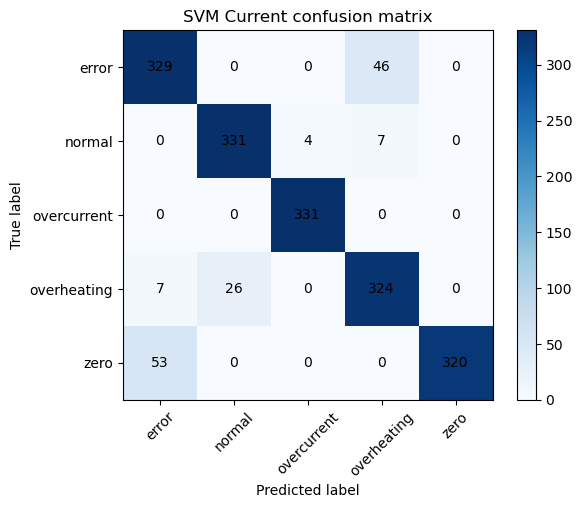

In [18]:
current_val_cm = evaluate_and_print_results(model=svm_current, X_test=X_val_current, y_test=y_validation, label_encoder=label_encoder)
conf_matrix_plot(current_val_cm, "SVM Current")

              precision    recall  f1-score   support

       error       0.94      0.95      0.95       375
      normal       1.00      0.97      0.99       342
 overcurrent       0.99      1.00      0.99       331
 overheating       0.99      0.99      0.99       357
        zero       0.95      0.95      0.95       373

    accuracy                           0.97      1778
   macro avg       0.97      0.97      0.97      1778
weighted avg       0.97      0.97      0.97      1778


Custom reports
Precision: 0.9714541213383711
Recall: 0.9713160854893138
Accuracy: 0.9713160854893138
F1-Score (Micro): 0.9713160854893138
F1-Score (Macro): 0.9722270429325798
F1-Score (Weighted): 0.9713430630499438
Macro-average AUC (SVM): 0.9987899307855977


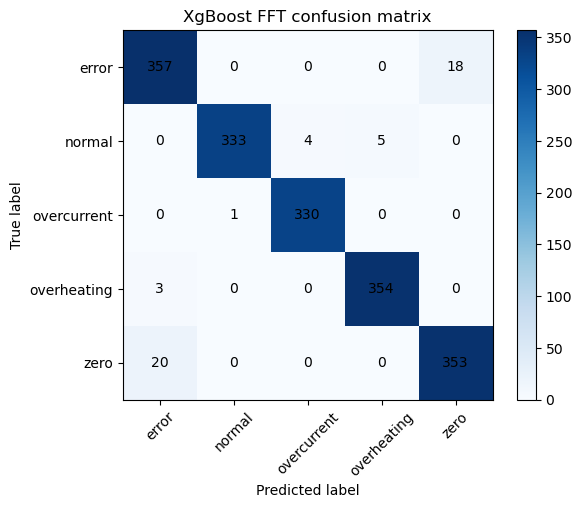

In [19]:
xgboost_val_cm = evaluate_and_print_results(model = xgboost_fft, X_test=X_validation_601, y_test=y_validation, label_encoder=label_encoder)
conf_matrix_plot(xgboost_val_cm, "XgBoost FFT")

### Fusion decision of the 2 models

In [20]:
xgboost_train_fft_pred_probs = xgboost_fft.predict_proba(X_train_601)
svm_train_current_pred_probs = svm_current.predict_proba(X_train_current)
pred_probs_concat = np.concatenate((xgboost_train_fft_pred_probs, svm_train_current_pred_probs), axis=1)

In [ ]:
pred_probs_concat.shape

(8290, 10)

In [ ]:
from sklearn.svm import SVC
# default
svm_fusion = SVC(kernel='rbf', random_state=42, probability=True)
svm_fusion.fit(pred_probs_concat, y_train)

SVC(probability=True, random_state=42)

In [ ]:
from xgboost import XGBClassifier
xgboost_fusion = XGBClassifier(objective='binary:logistic', tree_method="gpu_hist")
xgboost_fusion.fit(pred_probs_concat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
xgb_val_pp = xgboost_fft.predict_proba(X_validation_601)
svm_val_pp = svm_current.predict_proba(X_val_current)
validation_fusion_pred_prob = np.concatenate((xgb_val_pp, svm_val_pp), axis=1)
validation_fusion_pred_prob.shape

(1778, 10)

In [ ]:
evaluate_and_print_results(model = svm_fusion, X_test=validation_fusion_pred_prob, y_test=y_validation, label_encoder=label_encoder)

              precision    recall  f1-score   support

       error       0.93      0.95      0.94       375
      normal       1.00      0.97      0.99       342
 overcurrent       0.99      1.00      0.99       331
 overheating       0.99      0.99      0.99       357
        zero       0.95      0.94      0.94       373

    accuracy                           0.97      1778
   macro avg       0.97      0.97      0.97      1778
weighted avg       0.97      0.97      0.97      1778


Custom reports
Precision: 0.9698190927579664
Recall: 0.96962879640045
Accuracy: 0.96962879640045
F1-Score (Micro): 0.96962879640045
F1-Score (Macro): 0.9706273983119992
F1-Score (Weighted): 0.9696609354162729
Macro-average AUC (SVM): 0.9919491838064989


array([[357,   0,   0,   0,  18],
       [  0, 333,   4,   5,   0],
       [  0,   1, 330,   0,   0],
       [  3,   0,   0, 354,   0],
       [ 23,   0,   0,   0, 350]])

In [ ]:
evaluate_and_print_results(model=xgboost_fusion, X_test=validation_fusion_pred_prob, y_test=y_validation, label_encoder=label_encoder)

              precision    recall  f1-score   support

       error       0.97      0.89      0.93       375
      normal       0.98      0.98      0.98       342
 overcurrent       0.99      0.98      0.99       331
 overheating       0.99      0.99      0.99       357
        zero       0.90      0.98      0.94       373

    accuracy                           0.96      1778
   macro avg       0.96      0.96      0.96      1778
weighted avg       0.96      0.96      0.96      1778


Custom reports
Precision: 0.9637134097019112
Recall: 0.9623172103487064
Accuracy: 0.9623172103487064
F1-Score (Micro): 0.9623172103487064
F1-Score (Macro): 0.9633651690394032
F1-Score (Weighted): 0.9622707222838979
Macro-average AUC (SVM): 0.9980297607802513


array([[333,   0,   0,   0,  42],
       [  0, 334,   3,   5,   0],
       [  0,   6, 325,   0,   0],
       [  3,   0,   0, 354,   0],
       [  8,   0,   0,   0, 365]])